## Import libraries

In [4]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.preprocessing import StandardScaler

has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [5]:
# HYPERPARAMETERS
SEQUENCE_SIZE = 3
dataset_path = "ParkingDataDataset.txt"
split_ratio = 0.7 # 70% training, 30% testing
batch_size = 32

# Regarding training loop
epochs = 1000
min_val_loss = float('inf')
learning_rate = 0.001

## Load dataset

In [6]:
# read text file into pandas DataFrame
df = pd.read_csv(dataset_path, sep="\t")
df.head(10)

,DateTime,Car ID,Vehicle,VType,Day,ReqT,EntHr,EntMin,ExitHr,ExitMin,...,Tries,DFS,IdleVeh,tFree,z1Free,z2Free,z3Free,z4Free,dReq,Unnamed: 27
0,2022-01-01 08:25:00,936,Student,3,1,406,8,25,8,32,...,1,365,5,93,14,49,8,22,1,NaN
1,2022-01-01 08:25:00,937,Faculty,2,1,1333,8,25,8,47,...,1,354,6,93,14,49,8,22,1,NaN
2,2022-01-01 08:00:00,942,Staff,5,1,8883,8,0,8,0,...,2,672,17,0,0,0,0,0,1,NaN
3,2022-01-01 08:39:00,948,Visitor,1,1,1143,8,39,8,58,...,1,365,12,88,12,46,8,22,1,NaN
4,2022-01-01 08:00:00,983,Student,3,1,7432,8,0,8,0,...,2,672,15,0,0,0,0,0,2,NaN
5,2022-01-01 08:55:00,959,Faculty,2,1,731,8,55,9,8,...,1,354,17,74,3,41,8,22,2,NaN
6,2022-01-01 08:00:00,975,Faculty,2,1,4296,8,0,8,0,...,2,672,12,0,0,0,0,0,2,NaN
7,2022-01-01 09:21:00,977,Student,3,1,95,9,21,9,22,...,1,365,16,60,1,29,8,22,3,NaN
8,2022-01-01 09:16:00,984,Student,3,1,424,9,16,9,23,...,1,354,17,62,1,31,8,22,3,NaN
9,2022-01-01 08:00:00,992,Faculty,2,1,7713,8,0,8,0,...,2,672,14,0,0,0,0,0,6,NaN


In [7]:
df.columns

Index(['DateTime            ', 'Car ID', 'Vehicle', 'VType', 'Day', 'ReqT',
       'EntHr', 'EntMin', 'ExitHr', 'ExitMin', 'TDelay', 'IdleT', 'TBill',
       'Fine', 'PL No.', 'PLZone', 'nFree', 'nFill', 'Tries', 'DFS', 'IdleVeh',
       'tFree', 'z1Free', 'z2Free', 'z3Free', 'z4Free', 'dReq', 'Unnamed: 27'],
      dtype='object')

## Pre-process the dataset

In [8]:
# PREPROCESS THE MAIN DATASET TO GET CLEANED DATA
cleaned_df = df.copy()

# dropping useless columns
cleaned_df.drop('Car ID', inplace=True, axis=1)
cleaned_df.drop('Unnamed: 27', inplace=True, axis=1)
cleaned_df.drop('VType', inplace=True, axis=1)

# dropping useless rows
cleaned_df.drop(cleaned_df[cleaned_df['tFree'] == 0].index, inplace = True)
cleaned_df.drop(cleaned_df[cleaned_df['EntMin'] == 60] .index, inplace = True)

# creating datetime index column
cleaned_df['datetime'] = cleaned_df.iloc[:, 0]
cleaned_df.datetime = pd.to_datetime(cleaned_df.datetime)
cleaned_df.set_index(cleaned_df.datetime)
print('Index Column Created!')

# Sorting the data
cleaned_df = cleaned_df.sort_values(by=['Day', 'EntHr'], ascending=[True, True])

# creating new dataframe for model input
bill_df = cleaned_df.drop(cleaned_df.loc[:, cleaned_df.columns != "TBill"], axis=1)
# bill_df['datetime'] = cleaned_df.datetime
bill_df.set_index(cleaned_df.datetime, inplace=True)
bill_df.head()


Index Column Created!


,TBill
datetime,
2022-01-01 08:25:00,8
2022-01-01 08:25:00,39
2022-01-01 08:39:00,48
2022-01-01 08:55:00,21
2022-01-01 08:49:00,52


In [9]:
# aggregate
ts = bill_df['TBill'].resample('H').sum()
ts = ts.to_frame()
ts.head()

,TBill
datetime,
2022-01-01 08:00:00,4818
2022-01-01 09:00:00,4682
2022-01-01 10:00:00,3459
2022-01-01 11:00:00,4458
2022-01-01 12:00:00,4160


<Axes: xlabel='datetime'>

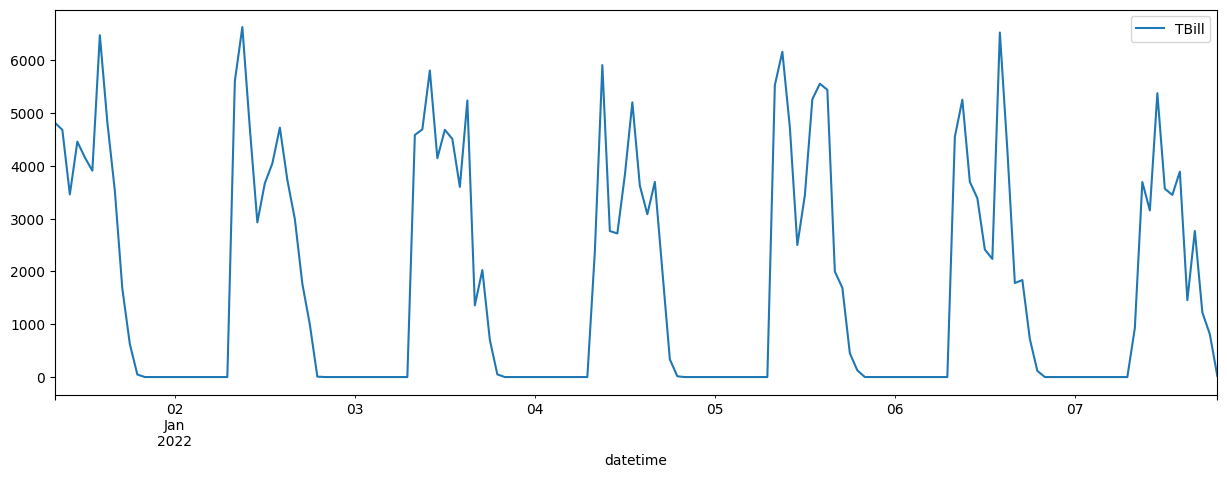

In [10]:
# plotting the aggregated series
ts.plot(figsize=(15, 5))

In [11]:
# SPLIT THE MAIN DATASET INTO TRAIN AND TEST DATASETS
# Determine the split point based on the desired ratio (80% train, 20% test)
split_index = int(split_ratio * len(ts))

# Split the data into training and testing datasets
df_train = ts.iloc[:split_index]
df_test = ts.iloc[split_index:]

In [12]:
# EXTRACT ONLY WHAT'S REQUIRED FROM THE DATASET
bill_train_unscaled = df_train['TBill'].to_numpy().reshape(-1, 1)
bill_test_unscaled = df_test['TBill'].to_numpy().reshape(-1, 1)

scaler = StandardScaler()
bill_train = scaler.fit_transform(bill_train_unscaled).flatten().tolist()
bill_test = scaler.transform(bill_test_unscaled).flatten().tolist()

In [13]:
# Sequence Data Preparation
def to_sequences(seq_size, obs):
    x = []
    y = []
    for i in range(len(obs) - seq_size):
        window = obs[i:(i + seq_size)]
        after_window = obs[i + seq_size]
        x.append(window)
        y.append(after_window)
    return torch.tensor(x, dtype=torch.float32).view(-1, seq_size, 1), torch.tensor(y, dtype=torch.float32).view(-1, 1)

x_train, y_train = to_sequences(SEQUENCE_SIZE, bill_train)
x_test, y_test = to_sequences(SEQUENCE_SIZE, bill_test)

# Setup data loaders for batch
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
print(x_train[:3])
print('-----------------')
print(y_train[:3])

tensor([[[1.3506],
         [1.2882],
         [0.7270]],

        [[1.2882],
         [0.7270],
         [1.1854]],

        [[0.7270],
         [1.1854],
         [1.0487]]])
-----------------
tensor([[1.1854],
        [1.0487],
        [0.9331]])


## Sarima model

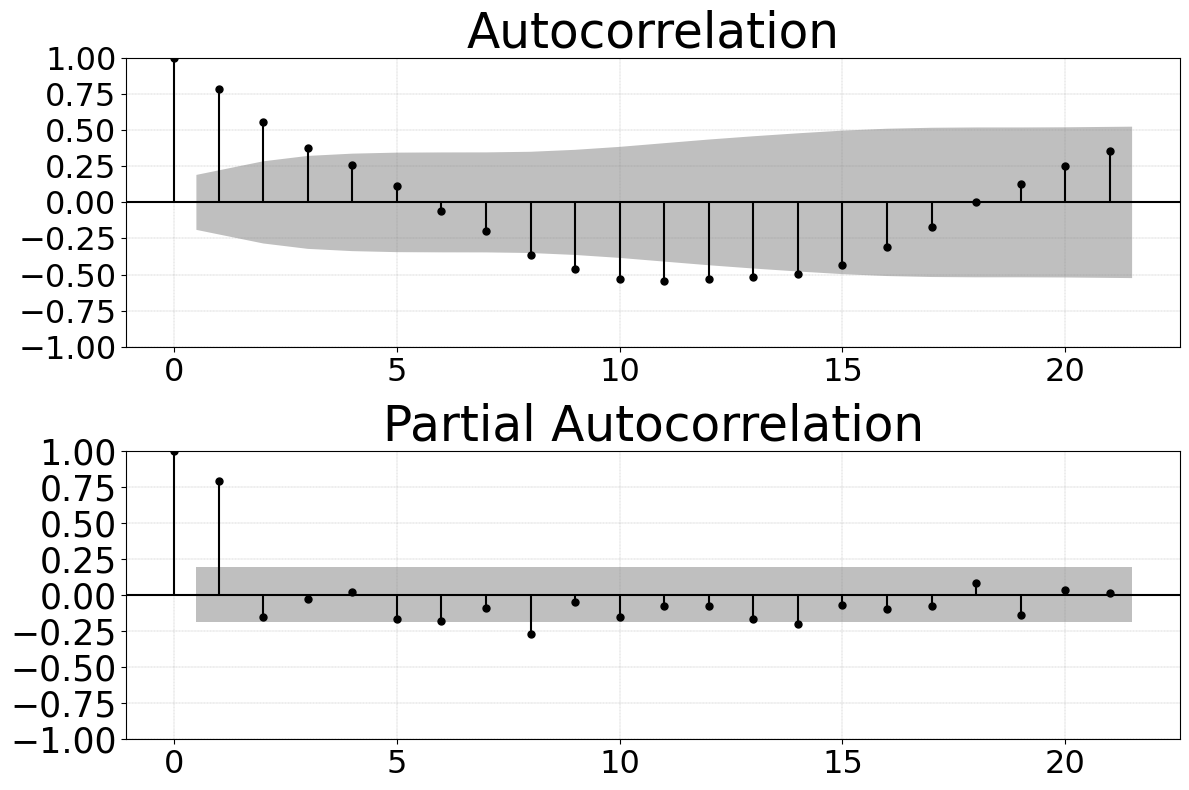

In [17]:
# selecting values of p and q
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from matplotlib.collections import PolyCollection
import matplotlib.pyplot as plt

my_color = 'black'

fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_train.iloc[SEQUENCE_SIZE:], ax=ax1, use_vlines=True, color=my_color, vlines_kwargs={"colors": my_color})

for item in ax1.collections:
    if type(item)==PolyCollection:
        item.set_facecolor(my_color)

ax1.grid(which="major", color="grey", linestyle="--", linewidth=0.20)
ax1.set_title("Autocorrelation", fontsize=35)

plt.yticks(fontsize=23)
plt.xticks(fontsize=23)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_train.iloc[SEQUENCE_SIZE:], ax=ax2, use_vlines=True, color=my_color, vlines_kwargs={"colors": my_color})

# Customising the appearance
for item in ax2.collections:
    if type(item)==PolyCollection:
        item.set_facecolor(my_color)

ax2.grid(which="major", color="grey", linestyle="--", linewidth=0.20)
ax2.set_title("Partial Autocorrelation", fontsize=35)

plt.yticks(fontsize=25)
plt.xticks(fontsize=23)

fig.tight_layout()

In [18]:
# the model
model = sm.tsa.statespace.SARIMAX(df_train['TBill'], order=(1,1,0), seasonal_order=(0,1,1,24))

# fitting the model
sarima_model = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


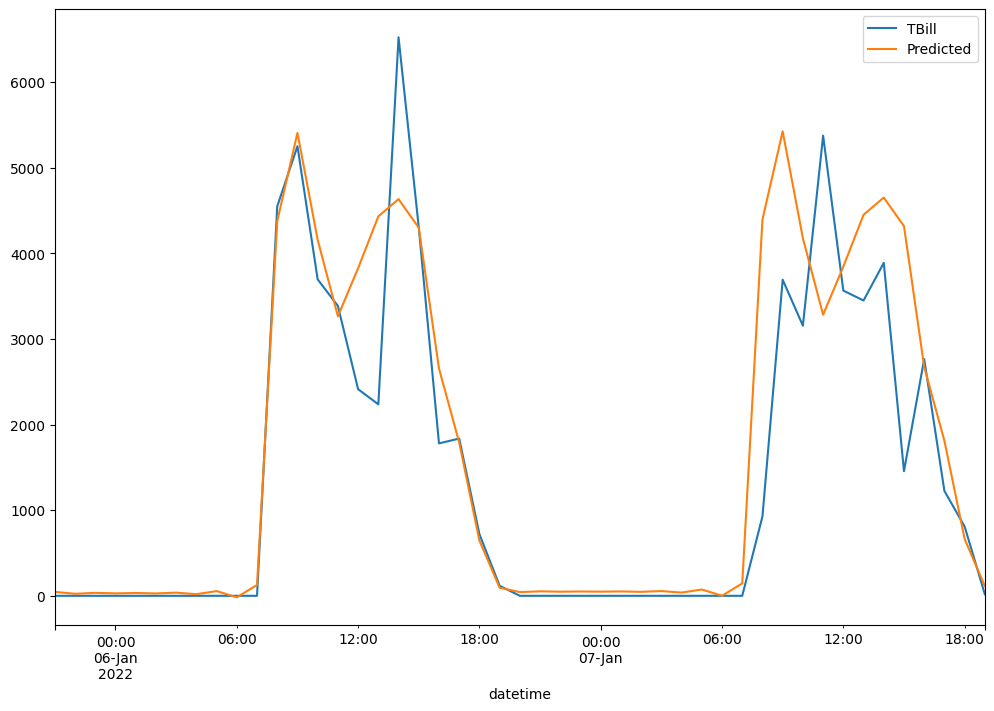

In [19]:
# getting evaluation on test set
predicted_ts = sarima_model.predict(df_test.index[0], df_test.index[-1])

# visualizing accuracy of the model on training data
df_test.plot(figsize=(12,8), label='Actual')
predicted_ts.plot(figsize=(12,8), label='Predicted')
plt.legend()
plt.show()

## GRU model

In [20]:
# Bidirectional LSTM model
class BiLSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# Instantiate the model
gru_model = BiLSTMModel().to(device)

## LSTM model

In [21]:
# Simple LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# Instantiate the model
lstm_model = LSTMModel().to(device)


## Bidirectional LSTM model

In [22]:
# Bidirectional LSTM model
class BiLSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# Instantiate the model
b_lstm_model = BiLSTMModel().to(device)

## CNN model

In [23]:
class CNNModel(nn.Module):
    def __init__(self, input_size=3, conv_channels=[32, 64, 128, 256], fc_hidden_sizes=[256, 128], output_size=1):
        super(CNNModel, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=conv_channels[0], kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=conv_channels[0], out_channels=conv_channels[1], kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=conv_channels[1], out_channels=conv_channels[2], kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=conv_channels[2], out_channels=conv_channels[3], kernel_size=3, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(conv_channels[3], fc_hidden_sizes[0])
        self.fc2 = nn.Linear(fc_hidden_sizes[0], fc_hidden_sizes[1])
        self.fc3 = nn.Linear(fc_hidden_sizes[1], output_size)

        # Activation functions
        self.relu = nn.ReLU()

    def forward(self, x):
        # Input shape: (batch_size, seq_len, input_size)

        # Convolutional layers
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))

        # Global average pooling
        x = F.adaptive_avg_pool1d(x, 1).squeeze()

        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x

# Instantiate the more complex model
cnn_model = CNNModel().to(device)

## Transformer model

In [24]:
# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# Model definition using Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, d_model=64, nhead=4, num_layers=2, dropout=0.2):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x

transformer_model = TransformerModel().to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


## Training gru


In [25]:
# Train the gru_model
early_stop_count = 0
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gru_model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

for epoch in range(epochs):
    gru_model.train()
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = gru_model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    gru_model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = gru_model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 5:
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")


Epoch 1/1000, Validation Loss: 0.6865
Epoch 2/1000, Validation Loss: 0.6573
Epoch 3/1000, Validation Loss: 0.6226
Epoch 4/1000, Validation Loss: 0.5792
Epoch 5/1000, Validation Loss: 0.5271
Epoch 6/1000, Validation Loss: 0.4773
Epoch 7/1000, Validation Loss: 0.4483
Epoch 8/1000, Validation Loss: 0.4546
Epoch 9/1000, Validation Loss: 0.4731
Epoch 10/1000, Validation Loss: 0.4654
Epoch 11/1000, Validation Loss: 0.4412
Epoch 12/1000, Validation Loss: 0.4197
Epoch 13/1000, Validation Loss: 0.4095
Epoch 14/1000, Validation Loss: 0.4037
Epoch 15/1000, Validation Loss: 0.4019
Epoch 16/1000, Validation Loss: 0.4069
Epoch 17/1000, Validation Loss: 0.4036
Epoch 18/1000, Validation Loss: 0.4002
Epoch 19/1000, Validation Loss: 0.3970
Epoch 20/1000, Validation Loss: 0.3886
Epoch 21/1000, Validation Loss: 0.3869
Epoch 22/1000, Validation Loss: 0.3853
Epoch 23/1000, Validation Loss: 0.3801
Epoch 24/1000, Validation Loss: 0.3713
Epoch 25/1000, Validation Loss: 0.3675
Epoch 26/1000, Validation Loss: 0.

## Train LSTM

In [26]:
# Train the lstm_model
early_stop_count = 0
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

for epoch in range(epochs):
    lstm_model.train()
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = lstm_model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    lstm_model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = lstm_model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 5:
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")


Epoch 1/1000, Validation Loss: 0.7042
Epoch 2/1000, Validation Loss: 0.6927
Epoch 3/1000, Validation Loss: 0.6791
Epoch 4/1000, Validation Loss: 0.6634
Early stopping!


## Train Bidirectional LSTM

In [27]:
# Train the b_lstm_model
early_stop_count = 0
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(b_lstm_model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

for epoch in range(epochs):
    b_lstm_model.train()
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = b_lstm_model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    b_lstm_model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = b_lstm_model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 5:
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")


Epoch 1/1000, Validation Loss: 0.6970
Epoch 2/1000, Validation Loss: 0.6738
Epoch 3/1000, Validation Loss: 0.6469
Epoch 4/1000, Validation Loss: 0.6143
Early stopping!


## Train CNN

In [28]:
# Train the cnn_model
early_stop_count = 0
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

for epoch in range(epochs):
    cnn_model.train()
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = cnn_model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    cnn_model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = cnn_model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 5:
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")


Epoch 1/1000, Validation Loss: 0.7126
Epoch 2/1000, Validation Loss: 0.7053
Epoch 3/1000, Validation Loss: 0.6877
Epoch 4/1000, Validation Loss: 0.6472
Early stopping!


## Train Transformer

In [29]:
# Train the transformer_model
early_stop_count = 0
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

for epoch in range(epochs):
    transformer_model.train()
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = transformer_model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    transformer_model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = transformer_model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 5:
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")


Epoch 1/1000, Validation Loss: 0.8317
Epoch 2/1000, Validation Loss: 0.6367
Epoch 3/1000, Validation Loss: 0.3993
Epoch 4/1000, Validation Loss: 0.3914
Early stopping!


## Evaluation of models

In [30]:
# EVALUATION
model_dict = {
    'gru': gru_model,
    'lstm': lstm_model,
    'bidirectional lstm': b_lstm_model,
    'cnn': cnn_model,
    'transformer': transformer_model,
}
rmse_of_models = {}

# Define the evaluator function
def evaluator(model_name, model):
  global rmse_of_models
  model.eval()
  predictions = []
  with torch.no_grad():
      for batch in test_loader:
          x_batch, y_batch = batch
          x_batch = x_batch.to(device)
          outputs = model(x_batch)
          predictions.extend(outputs.squeeze().tolist())
  rmse = np.sqrt(np.mean((scaler.inverse_transform(np.array(predictions).reshape(-1, 1)) - scaler.inverse_transform(y_test.numpy().reshape(-1, 1)))**2))
  rmse = round(rmse, 2)
  rmse_of_models[model_name] = rmse

# Call the function for each model
for model_name, model in model_dict.items():
    evaluator(model_name, model)

# Special treatment for SARIMA MODEL
# getting evaluation on test set
predicted_ts_sarima = sarima_model.predict(df_test.index[0], df_test.index[-1])
rmse_sarima = np.sqrt(np.mean((np.array(predicted_ts_sarima).reshape(-1, 1) - np.array(df_test['TBill']).reshape(-1, 1))**2))
rmse_of_models['sarima'] = rmse_sarima

# Print results
for model_name, model in rmse_of_models.items():
    print(model_name, ':', model)

gru : 1292.9
lstm : 1805.22
bidirectional lstm : 1683.89
cnn : 1671.34
transformer : 1425.86
sarima : 947.914003432935


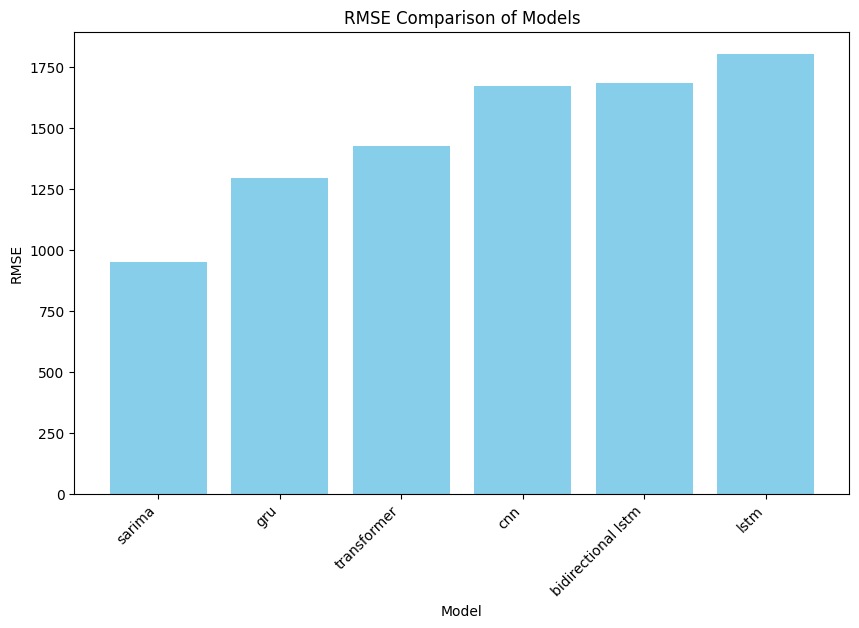

In [31]:
# Visualizing performanace of the models
import matplotlib.pyplot as plt

# Sorting the dictionary by values
sorted_rmse_of_models = dict(sorted(rmse_of_models.items(), key=lambda item: item[1]))

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(sorted_rmse_of_models.keys(), sorted_rmse_of_models.values(), color='skyblue')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE Comparison of Models')
plt.xticks(rotation=45, ha='right')
plt.show()


gru : 0.5254773706942746
lstm : 0.0749026531806819
bidirectional lstm : 0.19508218678395273
cnn : 0.20703762679052917
transformer : 0.4228637015298178
sarima : 0.7385719989395072


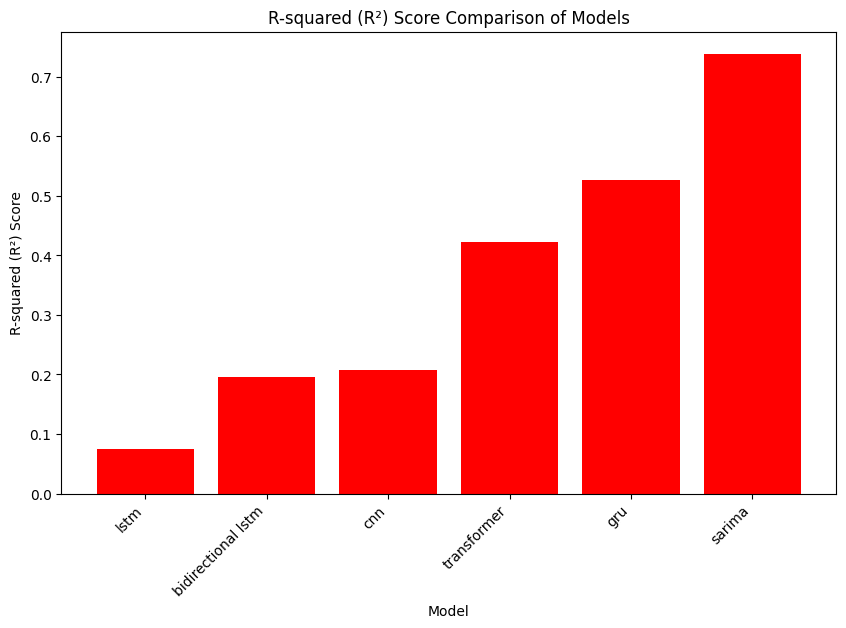

In [35]:
# Evaluating based on another metric
# EVALUATION
from sklearn.metrics import r2_score

model_dict = {
    'gru': gru_model,
    'lstm': lstm_model,
    'bidirectional lstm': b_lstm_model,
    'cnn': cnn_model,
    'transformer': transformer_model
}
r2_scores_of_models = {}

# Define the evaluator function
def evaluator(model_name, model):
    global r2_scores_of_models
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            x_batch = x_batch.to(device)
            outputs = model(x_batch)
            predictions.extend(outputs.squeeze().tolist())

    r2_score_value = r2_score(scaler.inverse_transform(y_test.numpy().reshape(-1, 1)),
                              scaler.inverse_transform(np.array(predictions).reshape(-1, 1)))
    r2_scores_of_models[model_name] = r2_score_value

# Call the function for each model
for model_name, model in model_dict.items():
    evaluator(model_name, model)

# Special treatment for SARIMA model
predicted_ts_sarima = sarima_model.predict(df_test.index[0], df_test.index[-1])
# Calculate R2 score
r2_sarima = r2_score(df_test['TBill'], predicted_ts_sarima)
r2_scores_of_models['sarima'] = r2_sarima

# Print results
for model_name, model in r2_scores_of_models.items():
    print(model_name, ':', model)

# Plotting code
# Visualizing performance of the models
import matplotlib.pyplot as plt

# Sorting the dictionary by values
sorted_r2_scores_of_models = dict(sorted(r2_scores_of_models.items(), key=lambda item: item[1]))

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(sorted_r2_scores_of_models.keys(), sorted_r2_scores_of_models.values(), color='red')
plt.xlabel('Model')
plt.ylabel('R-squared (R²) Score')
plt.title('R-squared (R²) Score Comparison of Models')
plt.xticks(rotation=45, ha='right')
plt.show()


R-squared (R²) score measures the proportion of the variance in the dependent variable that is predictable from the independent variable(s). It's often used to assess how well the model fits the data. The score ranges from 0 to 1, where 1 indicates a perfect fit.



A higher R-squared (R²) score for a GRU model implies that the model performs better in explaining the variance in the target variable compared to the other models in the comparison

## Forecasting

<Axes: xlabel='datetime'>

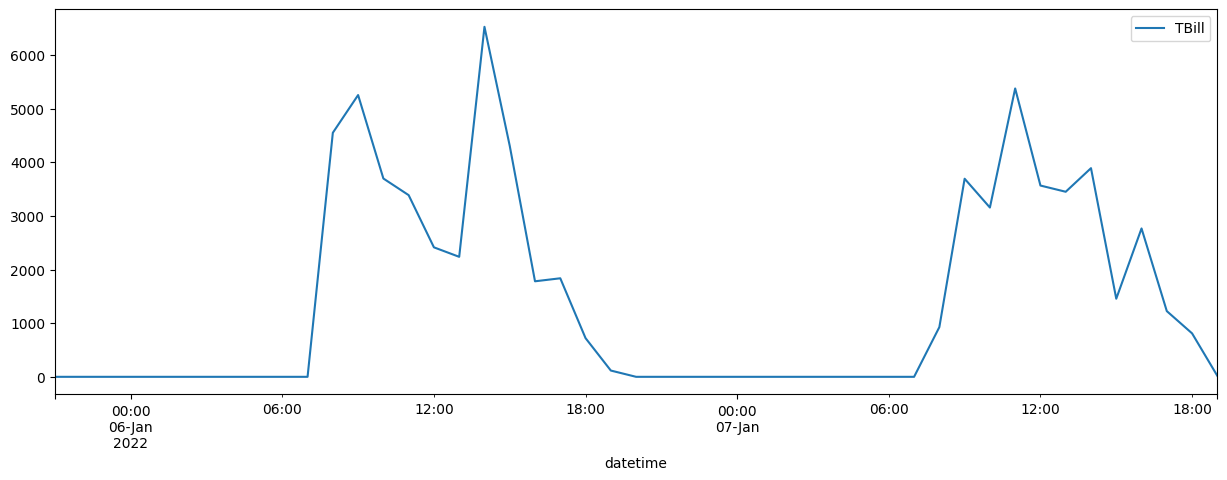

In [33]:
# plotting the aggregated series (ACTUAL TEST DATA)
df_test.plot(figsize=(15, 5))

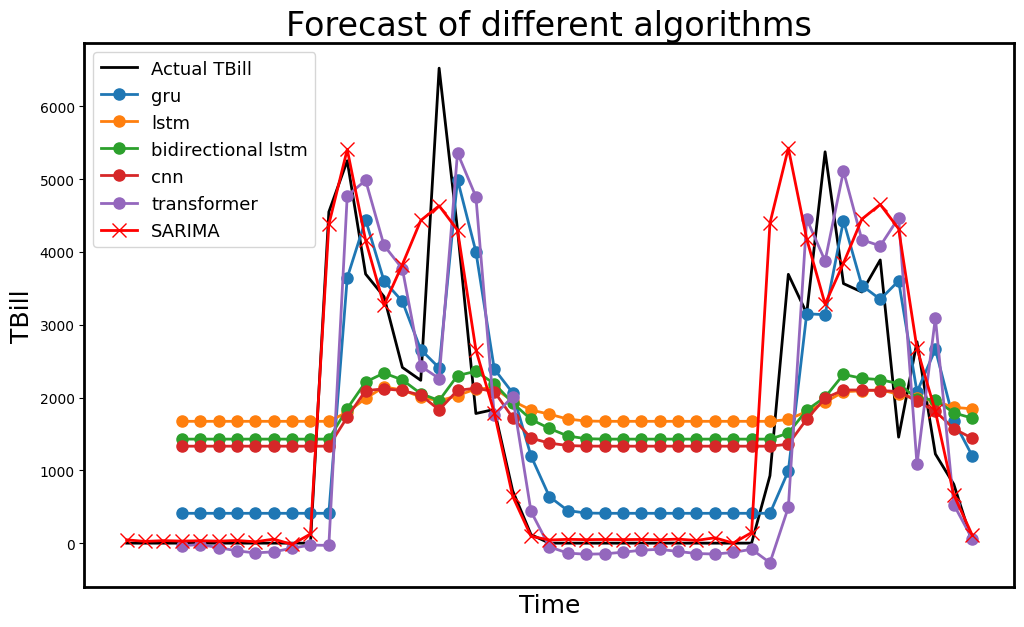

In [48]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_sarima_predictions():
    predicted_ts.plot(figsize=(12, 8), label='SARIMA', color='red', marker='x', markersize=10, linewidth=2)  # Adjusted marker size and linewidth

def plot_predictions(model_name, model):
    model.eval()
    all_predictions = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            x_batch = x_batch.to(device)
            outputs = model(x_batch)
            all_predictions.extend(outputs.squeeze().tolist())
    # Convert predictions to original scale
    all_predictions = scaler.inverse_transform(np.array(all_predictions).reshape(-1, 1))
    # Plotting Transformer predictions
    plt.plot(df_test.index[SEQUENCE_SIZE:], all_predictions, label=model_name, marker='o', markersize=8, linewidth=2)  # Adjusted marker size and linewidth

# Plotting the actual bill data
plt.figure(figsize=(14, 7))  # Adjusted figure size
plt.plot(df_test.index, scaler.inverse_transform(np.array(bill_test).reshape(-1, 1)), label='Actual TBill', color='black', linewidth=2)  # Adjusted linewidth

# Plotting predicted results
for model_name, model in model_dict.items():
    plot_predictions(model_name, model)
plot_sarima_predictions()

# Formatting the plot
plt.title('Forecast of different algorithms', fontsize=24)  # Adjusted title font size
plt.xlabel('Time', fontsize=18)  # Adjusted x-axis label font size
plt.ylabel('TBill', fontsize=18)  # Adjusted y-axis label font size
plt.legend(fontsize=13, loc='upper left')  # Adjusted legend font size
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Adjusted axis thickness
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)

# Display the plot
plt.show()


GRU and transformer are better forecasting the future. But sarima is the best!


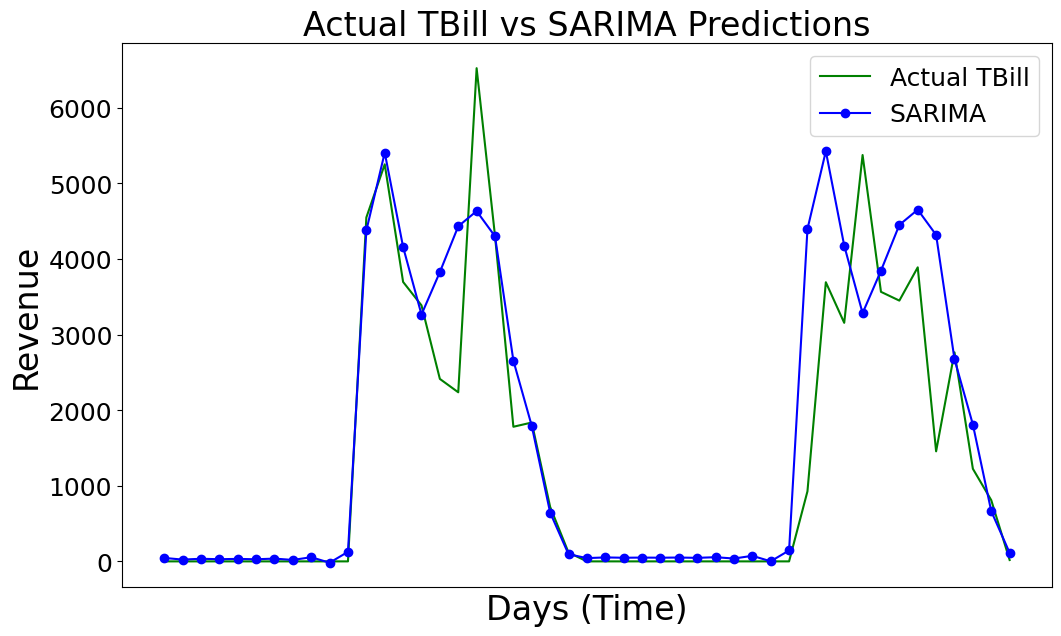

In [43]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_sarima_predictions():
    predicted_ts.plot(figsize=(12, 8), label='SARIMA', color='blue', marker='o')

# Plotting the actual bill data
plt.figure(figsize=(12, 6))
plt.plot(df_test.index, scaler.inverse_transform(np.array(bill_test).reshape(-1, 1)), label='Actual TBill', color='green')

# Plotting predicted results
plot_sarima_predictions()

# Formatting the plot
plt.title('Actual TBill vs SARIMA Predictions', fontsize=24, color='black')
leg = plt.legend(fontsize=18, loc="upper right")
for text in leg.get_texts():
    text.set_color("black")

# Explicitly set legend title color
leg.get_title().set_color("black")

plt.xlabel("Days (Time)", fontsize=24, color='black')
plt.ylabel("Revenue", fontsize=24, color='black')
plt.yticks(fontsize=18, color='black')
plt.xticks(fontsize=18, color='black')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Display the plot
plt.show()
